<a href="https://colab.research.google.com/github/JuliaOlif/Mind-Reading-/blob/main/MindReading_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Function to install nilearn - Please run this first
!pip install nilearn

# Week 2: Volumes, Surfaces, and Segmentation

In this tutorial, we will further explore anatomical neuroimaging data. Specifically, we will separate different tissues types and reconstruct cortical surfaces from volumetric data.

**Learning objectives**  
- Understand how tissue segmentation works in neuroimaging  
- Understand how cortical surfaces are reconstructed from volumetric data  
- Learn to use nilearn for volume manipulation and visualization

**Estimated time to complete:** 1 hour




In [47]:
# Please run this cell to download the required data for this tutorial

import os
import urllib.request

def download_file(url, outfile):
    """Download file from URL if not already present."""
    if not os.path.exists(outfile):
        print(f"Downloading {outfile}...")
        urllib.request.urlretrieve(url, outfile)
        print(f"Saved as {outfile}")
    else:
        print(f"{outfile} already exists, skipping download.")

# Downloading some required data
download_file(
    "https://www.dropbox.com/scl/fi/h1pjjm093wyw8luxig79s/sub-0001_run-1_T1w.nii.gz?rlkey=3m5ymyhc84teumfy3zthc4n9m&dl=1",
    "anat.nii.gz"
)

download_file(
    "https://www.dropbox.com/scl/fi/gs6d5z8ead8dsz973yhby/sub-0001_run-1_T1w_brain_mask.nii.gz?rlkey=0a3ouzwseuywev8fc8ddtzvvw&dl=1",
    "anat_mask.nii.gz"
)

download_file(
    "https://www.dropbox.com/scl/fi/wxdake9xe7us76a8a0rsy/data-cortical_type-aparc_measure-thickness_hemi-lh.tsv?rlkey=uc1rq8hdwghicylwirc0nm676&dl=1",
    "thickness_lh.tsv"
)

download_file(
    "https://www.dropbox.com/scl/fi/zvv2i8iaa9zhojynedlyo/sub-0001_run-1_T1w_mixeltype.nii.gz?rlkey=b302sgj4bduk4bmi7apwvldbi&dl=1",
    "mixeltype.nii.gz"
)

anat.nii.gz already exists, skipping download.
anat_mask.nii.gz already exists, skipping download.
thickness_lh.tsv already exists, skipping download.
mixeltype.nii.gz already exists, skipping download.


#### Recap: Volumetric Neuroimaging Data

Last week, we saw that volumetric neuroimaging data, such as MRI scans, are typically stored in a 3D grid format where each element (voxel) represents a specific location in the brain. Each voxel contains intensity values that correspond to the properties of the tissue at that location. We also saw that the histogram of these intensity values can provide insights into the different tissue types present in the brain:

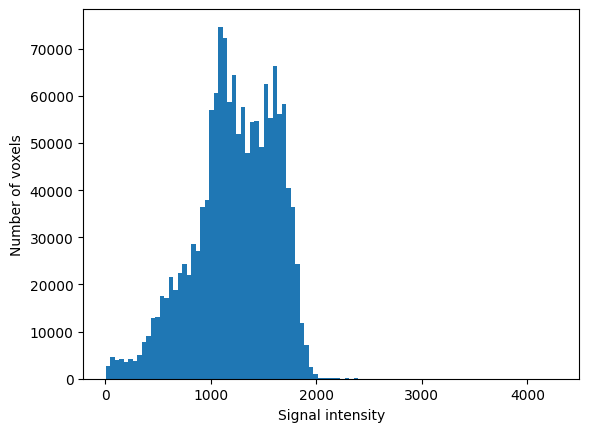

In [48]:
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

# Loading the data and applying the brain mask
img = nib.load('anat.nii.gz')
img_data = img.get_fdata()
mask_data = nib.load('anat_mask.nii.gz').get_fdata()
brain_img_data = img_data * mask_data
brain_img = nib.Nifti1Image(brain_img_data, img.affine)

# Plotting the histogram of brain voxel intensities
img_values = brain_img.get_fdata().flatten() # Flatten the array to make it 1D
img_values = img_values[img_values > 0] # Remove the background
plt.hist(img_values, bins=100)
plt.xlabel('Signal intensity')
plt.ylabel('Number of voxels')
plt.show()

### Segmentation: Finding different tissue types
The different intensities often correspond to different tissue types, such as gray matter, white matter, and cerebrospinal fluid (CSF). By analyzing these intensity distributions, we can begin to classify and segment the brain into its constituent tissues. Let's see what the different intensity values correspond to in this MRI scan, by diving the histogram into three segments.

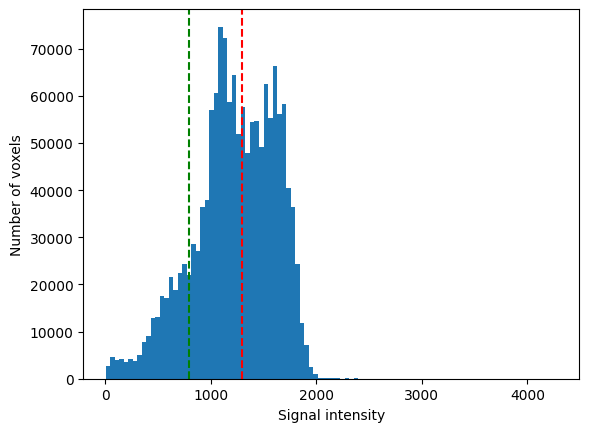

In [49]:
# Plotting the histogram of brain voxel intensities
img_values = brain_img.get_fdata().flatten() # Flatten the array to make it 1D
img_values = img_values[img_values > 0] # Remove the background
plt.hist(img_values, bins=100)
plt.axvline(x=800, color='g', linestyle='--', label='CSF threshold')
plt.axvline(x=1300, color='r', linestyle='--', label='GM/WM threshold')
plt.xlabel('Signal intensity')
plt.ylabel('Number of voxels')
plt.show()

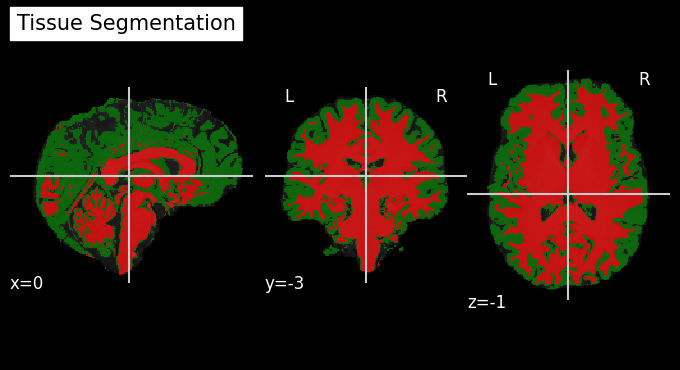

In [50]:
import numpy as np
from matplotlib.colors import ListedColormap

segmentation_img_data = np.zeros(brain_img_data.shape)
segmentation_img_data[(brain_img_data > 800) & (brain_img_data <= 1300)] = 2  # GM
segmentation_img_data[brain_img_data > 1300] = 3  # WM
segmentation_img = nib.Nifti1Image(segmentation_img_data, img.affine)

# Creating a segmented colour map with distinct colors
cmap = ListedColormap(['green', 'red'])  # 0=background, 1=GM, 2=WM

# Visualizing the segmentation
plotting.plot_roi(
    segmentation_img,
    title="Tissue Segmentation",
    cmap=cmap,
    bg_img=brain_img,
    colorbar=False
    )


As you can see, the peaks in the histogram correspond to different tissue types. In T1-weighted images like this one, the middle values typically correspond to grey matter, the higher values to white matter, and the lower values to cerebrospinal fluid (CSF) and other non-brain tissues. However, the exact thresholds can vary between scans and individuals, and we wouldn't want to guess the thresholds manually. Instead, we can use automated methods to segment the brain into its different tissue types. Most neuroimaging software packages provide tools for this purpose, often based on probabilistic models that take into account the intensity distributions as well as spatial information.

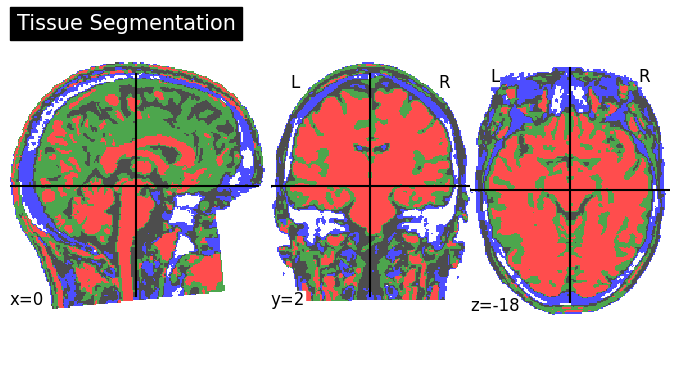

In [51]:
cmap = ListedColormap(['black', 'red', 'blue', 'green'])

plotting.plot_roi(
    'mixeltype.nii.gz',
    title="Tissue Segmentation",
    bg_img=None,
    cmap=cmap,
    vmax=5,
    colorbar=False
    )


The algorithm created a clear separation between the three main tissue types: gray matter, white matter, and cerebrospinal fluid (CSF). Each tissue type is represented by a different label in the segmentation map. These are presented as different values in the segmented image.

You can see from the visualisation above the that the cortex is highly folded, with many gyri (ridges) and sulci (grooves). This folding increases the surface area of the cortex, allowing for more neurons and synaptic connections, which is thought to enhance cognitive abilities.

### Surface Reconstruction
One limitation of volumetric data is that it can be challenging to accurately capture and represent these complex surface structures. To address this, we can reconstruct cortical surfaces from the volumetric data, which provides a more detailed and accurate representation of the brain's anatomy. The basic idea behind surface reconstruction is to create a mesh that follows the contours of the cortex, capturing its folds and grooves. FreeSurfer is a popular software package for cortical surface reconstruction and analysis. It uses a combination of intensity-based segmentation and geometric modeling to create accurate surface representations of the cortex. Let's visualize the reconstructed cortical surfaces using nilearn's plotting capabilities.

We can use the surface reconstruction to better understand the brain's anatomy and to perform more accurate analyses of brain function and structure. Surface-based analyses can provide insights into cortical thickness, surface area, and functional activation patterns that are not easily accessible from volumetric data alone. Cortical thickness, for example, is an important biomarker in many neurological and psychiatric conditions. It's caluclated as the distance between the white matter surface and the pial surface (the outer surface of the cortex).

![thickness](https://andysbrainbook.readthedocs.io/en/stable/_images/03_Orig_White_Pial.png)

The image above shows a simplified illustration of how cortical thickness is calculated. The lines represent the outline of the pial surface (outer layer, red) and the white matter surface (inner layer, blue). The distance between these two surfaces at various points across the cortex is measured to determine cortical thickness (red arrows).

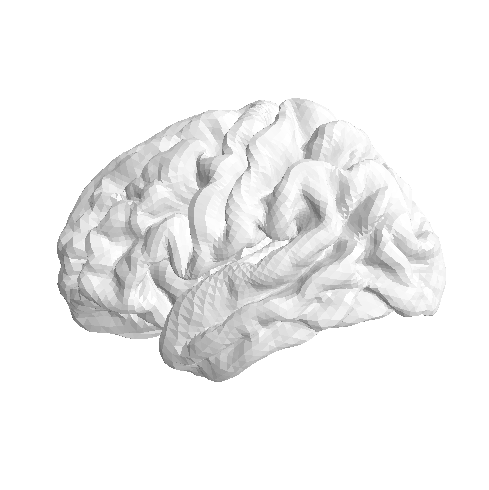

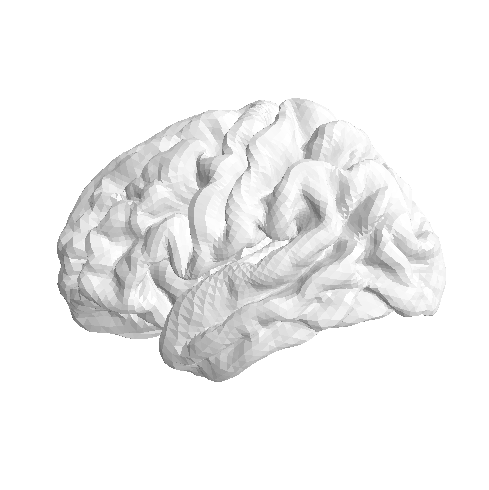

In [52]:
from nilearn.surface import SurfaceImage
from nilearn.datasets import load_fsaverage, load_fsaverage_data

# Loading the fsaverage meshes (standard surface)
fsaverage_meshes = load_fsaverage()
fsaverage_sulcal = load_fsaverage_data(data_type="sulcal")

# Plotting the pial surface with sulcal depth as background
plotting.plot_surf(
    fsaverage_meshes['pial'],
    bg_map=fsaverage_sulcal,
    hemi='left',
)

Some brain regions are difficult to see in views like this, because they are located within folds of the cortex, e.g. the insula. To better visualize these areas, we can create an "inflated" version of the cortical surface, which smooths out the folds while preserving the overall topology of the cortex. This allows us to see regions that would otherwise be hidden in the sulci.

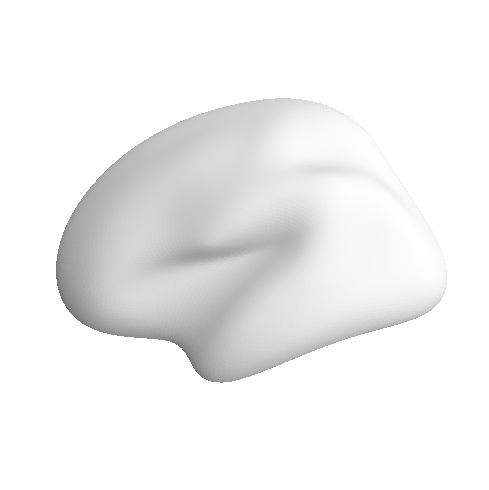

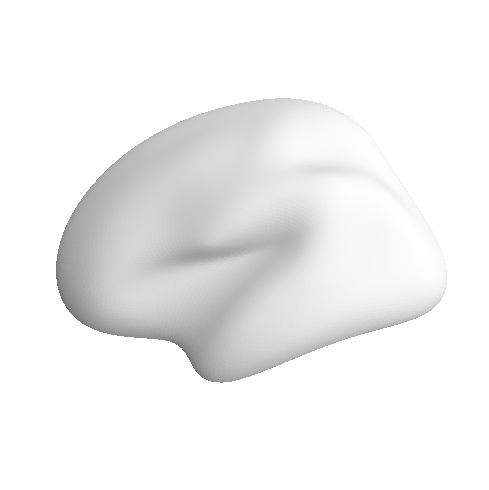

In [53]:
# Plotting the inflated surface with sulcal depth as background
plotting.plot_surf(
    fsaverage_meshes['inflated'],
    bg_map=fsaverage_sulcal,
    hemi='left',
)

**Question**: What could a drawback of using a highly inflated surface for visualsation? How could that limitation be overcome?

### Parcellation: Dividing the brain into regions
Another important concept in neuroimaging is parcellation, which involves dividing the brain into distinct regions based on anatomical or functional criteria. Parcellation schemes can be based on various factors, such as cytoarchitecture, connectivity patterns, or functional activation profiles. One commonly used anatomical parcellation is the Desikan-Killiany atlas, which divides the cerebral cortex into 34 regions per hemisphere based on gyral and sulcal landmarks. Functional parcellations, on the other hand, may be derived from resting-state fMRI data, identifying regions that exhibit similar patterns of activity over time.

The main advantage of parcellation is that it allows researchers to analyze brain data at the level of regions rather than individual voxels or vertices. This can help reduce noise and improve statistical power, as well as facilitate comparisons across subjects and studies. However, it's important to choose an appropriate parcellation scheme that aligns with the research question and the characteristics of the data being analyzed. Different parcellation schemes may yield different results, so careful consideration is needed when selecting one for a particular study.

![atlas](https://ielvis.pbworks.com/f/1564069551/desikanKillianyAtlasKey.png)

The image above shows the Desikan-Killiany atlas, with different colors representing different cortical regions. Each region is labeled with its corresponding name, such as "superior frontal gyrus" or "precuneus". This parcellation is based on anatomical landmarks and is widely used in neuroimaging research for region-based analyses.

In [54]:
import pandas as pd
thickness_data = pd.read_csv("thickness_lh.tsv", sep="\t")
thickness_data.head()

,lh.aparc.thickness,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,lh_MeanThickness_thickness,BrainSegVolNotVent,eTIV
0,sub-0001,2.597,2.861,2.832,1.666,3.718,2.751,2.565,2.873,2.493,...,2.240,3.052,2.663,2.394,4.019,2.872,3.216,2.61950,1176652.0,1.645965e+06
1,sub-0002,2.697,2.827,2.823,2.003,3.834,2.972,2.558,2.995,2.444,...,2.311,2.957,2.745,3.413,3.792,2.718,3.269,2.61559,1109034.0,1.532435e+06
2,sub-0003,2.647,2.924,2.825,1.732,3.421,2.743,2.550,2.854,2.316,...,2.289,2.847,2.818,3.355,4.008,2.455,3.320,2.58231,1059509.0,1.464556e+06
3,sub-0004,2.594,2.468,2.832,1.833,3.111,2.828,2.588,2.745,2.472,...,2.291,2.781,2.595,2.762,3.534,2.603,2.944,2.52487,1171454.0,1.625994e+06
4,sub-0005,2.703,2.656,2.674,1.945,3.295,2.694,2.510,2.789,2.265,...,2.246,2.834,2.611,3.015,3.866,2.486,3.077,2.52846,1386463.0,2.006237e+06


Let's visualize cortical thickness data on the left hemisphere using the Desikan-Killiany atlas across all participants in our dataset.

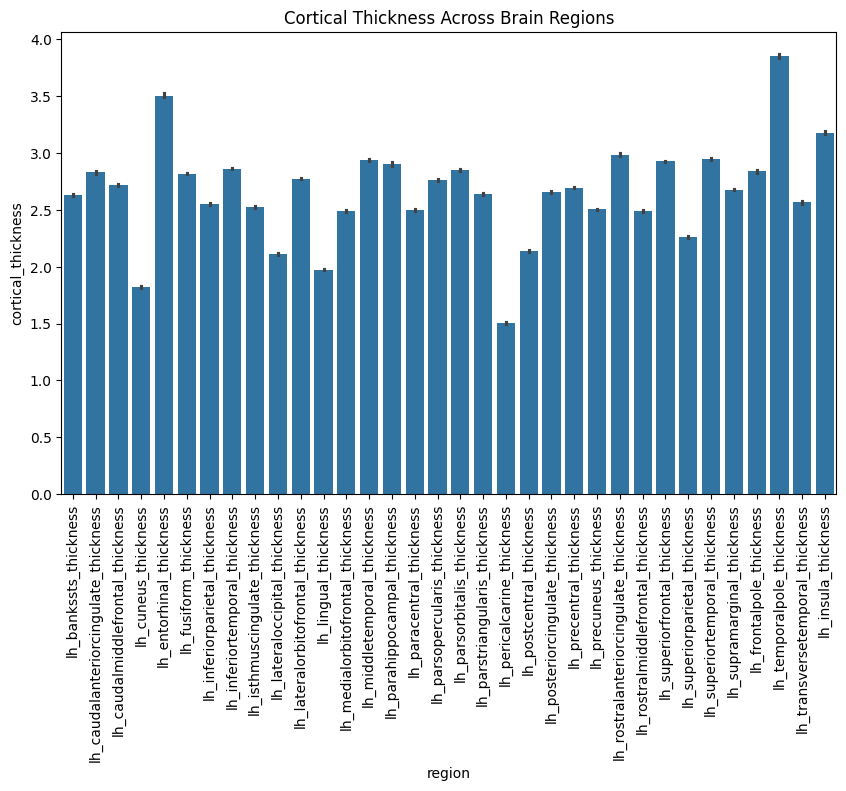

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Renaming the first column
thickness_data.rename(columns={'lh.aparc.thickness': 'participant_id'}, inplace=True)

# Selecting only the brain regions
regions = [column for column in thickness_data.columns if not column in ['participant_id', 'lh_MeanThickness_thickness', 'BrainSegVolNotVent', 'eTIV']]
thickness_data = thickness_data[['participant_id'] + regions]

# Melting the data for seaborn
melted_data = thickness_data.melt(id_vars='participant_id', value_vars=regions, var_name='region', value_name='cortical_thickness')

# Plotting cortical thickness across regions
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='cortical_thickness', data=melted_data)
plt.xticks(rotation=90)
plt.title('Cortical Thickness Across Brain Regions')
plt.show()

### Final Exercise:
Now that you have learned about tissue segmentation, surface reconstruction, and parcellation, it's time to apply these concepts in a practical exercise. Using the provided dataset, perform the following tasks:

#### 1. Calculate grey matter and white matter volume in the segmented image
- Apply the brain mask to the segmented image (`mixeltype.nii.gz`) to isolate brain tissues.
- Calculate the total volume of grey matter and white matter by counting the number of voxels corresponding to each tissue type and multiplying by the voxel volume (hint: use `img.get_zooms()` to get voxel dimensions).

#### 2. Analyse cortical thickness using the Desikan-Killiany atlas
- Using the cortical thickness data provided, compute the average cortical thickness for each region defined in the Desikan-Killiany atlas.
- Find the region with the maximum average cortical thickness and report its name and value.
- Find the region with the minimum average cortical thickness and report its name and value.
- Compare the cortical area where the cortical thickness of participant `sub-0001` is most different from the average cortical thickness across all participants. Report the region name and the difference in thickness.


Part 1: Calculating grey matter and white matter volume in a segmented image
Step 1 - Applying the brain mask to the segmented image to isolate brain tissue


In [56]:
# Loading the data and applying the brain mask

img2 = nib.load('mixeltype.nii.gz')
img2_data = img2.get_fdata()
mask_data2 = nib.load('anat_mask.nii.gz').get_fdata()
brain_img2_data = img2_data * mask_data2
brain_img2 = nib.Nifti1Image(brain_img2_data, img2.affine)


[0. 1. 2. 3. 4. 5.]


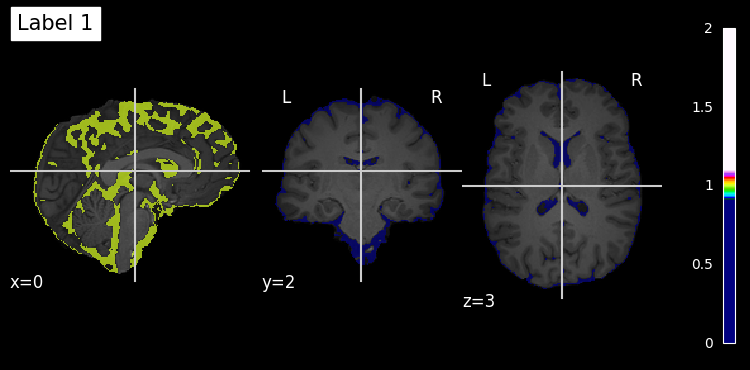

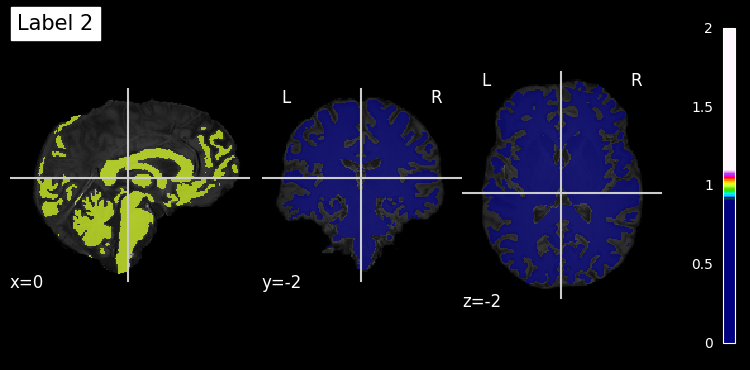

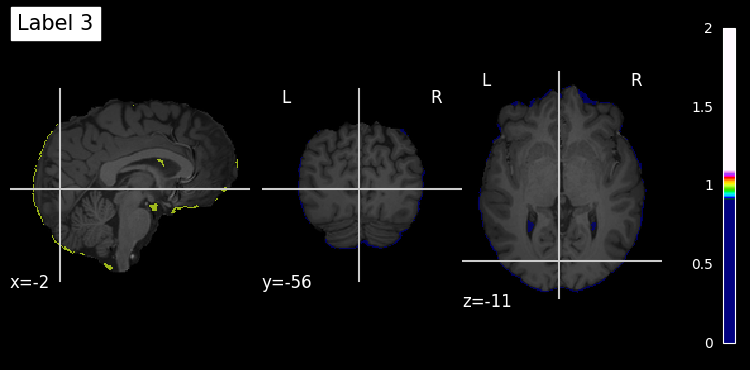

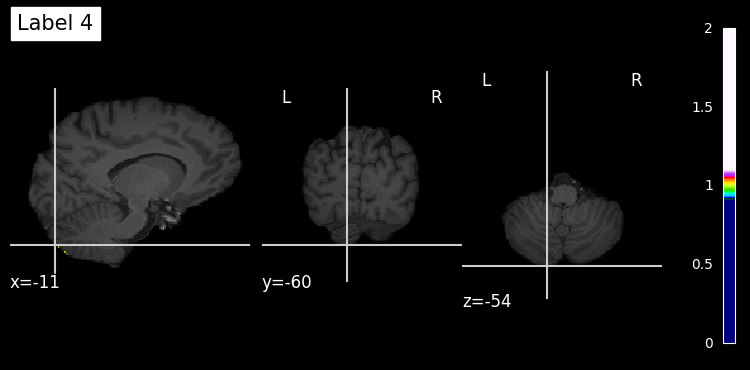

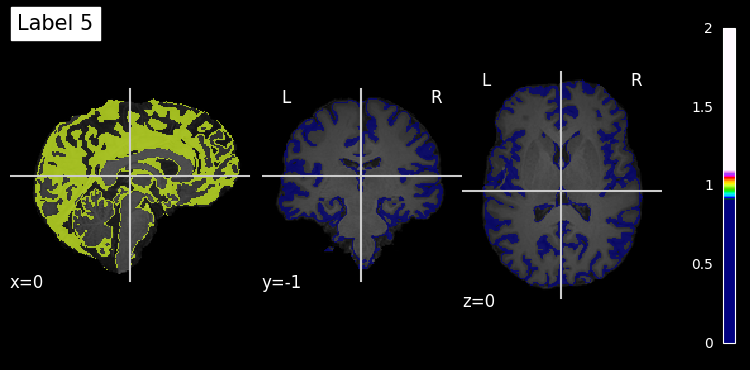

In [57]:
import numpy as np
print(np.unique(brain_img2.get_fdata()))

for label in [1, 2, 3, 4, 5]:
    label_img = nib.Nifti1Image((brain_img2.get_fdata() == label).astype(float), img2.affine)
    plotting.plot_roi(label_img, title=f"Label {label}", bg_img=brain_img)

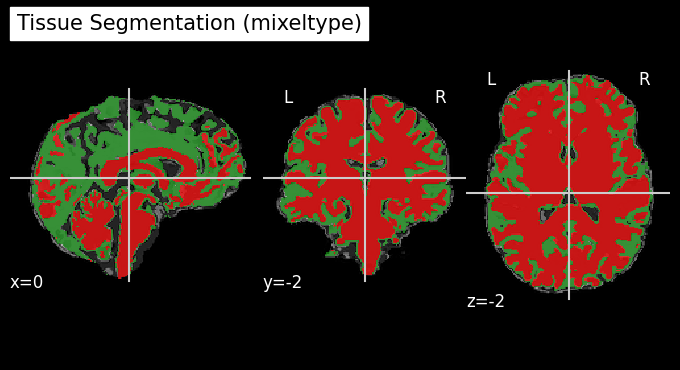

In [58]:
segmentation_img2_data = np.zeros(brain_img2_data.shape)
segmentation_img2_data[brain_img2_data == 5] = 2  # GM
segmentation_img2_data[brain_img2_data == 2] = 3  # WM
segmentation_img2 = nib.Nifti1Image(segmentation_img2_data, img2.affine)

cmap = ListedColormap(['green', 'red'])

plotting.plot_roi(
    segmentation_img2,
    title="Tissue Segmentation (mixeltype)",
    cmap=cmap,
    bg_img=brain_img2,
    colorbar=False
)

In [59]:
# Get voxel dimensions and calculate voxel volume
voxel_dims = img2.header.get_zooms()
voxel_volume = voxel_dims[0] * voxel_dims[1] * voxel_dims[2]  # mm³

# Count voxels for each tissue type
gm_voxels = np.sum(brain_img2_data == 5)
wm_voxels = np.sum(brain_img2_data == 2)

# Calculate volumes volume = number of voxels × size of each voxel.
gm_volume = gm_voxels * voxel_volume
wm_volume = wm_voxels * voxel_volume

print(f"Grey Matter Volume: {gm_volume:.2f} mm³")
print(f"White Matter Volume: {wm_volume:.2f} mm³")

Grey Matter Volume: 364684.00 mm³
White Matter Volume: 931423.00 mm³


Section 2 - Analyse cortical thickness using the Desikan-Killiany atlas

In [60]:
average_thickness = thickness_data[regions].mean()
print(average_thickness)

lh_bankssts_thickness                    2.633016
lh_caudalanteriorcingulate_thickness     2.832156
lh_caudalmiddlefrontal_thickness         2.721758
lh_cuneus_thickness                      1.821180
lh_entorhinal_thickness                  3.505746
lh_fusiform_thickness                    2.819401
lh_inferiorparietal_thickness            2.553279
lh_inferiortemporal_thickness            2.863089
lh_isthmuscingulate_thickness            2.525380
lh_lateraloccipital_thickness            2.111083
lh_lateralorbitofrontal_thickness        2.775377
lh_lingual_thickness                     1.975190
lh_medialorbitofrontal_thickness         2.489216
lh_middletemporal_thickness              2.941849
lh_parahippocampal_thickness             2.905209
lh_paracentral_thickness                 2.500747
lh_parsopercularis_thickness             2.762800
lh_parsorbitalis_thickness               2.852523
lh_parstriangularis_thickness            2.643182
lh_pericalcarine_thickness               1.507249


In [61]:
print(f"Max thickness region: {average_thickness.idxmax()}, value: {average_thickness.max():.4f} mm")
print(f"Min thickness region: {average_thickness.idxmin()}, value: {average_thickness.min():.4f} mm")

Max thickness region: lh_temporalpole_thickness, value: 3.8556 mm
Min thickness region: lh_pericalcarine_thickness, value: 1.5072 mm


In [62]:
# Get sub-0001's data
sub0001 = thickness_data[thickness_data['participant_id'] == 'sub-0001'][regions].squeeze()

# Calculate difference from average
difference = (sub0001 - average_thickness).abs()

print(f"Most different region: {difference.idxmax()}")
print(f"Difference in thickness: {difference.max():.4f} mm")

Most different region: lh_frontalpole_thickness
Difference in thickness: 0.4442 mm
